## Drought and Crop Yield

#### Project Proposal:
Throughout the years, droughts have received more attention especially by weather specialists. With climate change being actively tracked, it is important for us to understand drought patterns and how they will relate to crop yield, which will help us understand global food security for the coming years. Recently, there has been a growing food demand with an increase in the world population along with drastic changes in the weather patterns. Through this study, we plan to help farmers understand the extreme changes within weather patterns and how it will impact crop yield by understanding previous crop yield and loss patterns. 


#### Proposed Project: 
We will understand the relationship trend between crop yield and drought pattern in North and South America, and try to comprehend which crops are less correlated to drought data indications. Throughout this project, we will want to get a better knowledge of drought impact on agriculture and to extend further, how crops are currently affected by climate change. 

#### Questions to answer:
* Which crops are less correlated to drought data indications? If we have some crops that are less correlated, will this crop be a ‘good-yield’ crop in the areas that are more prone to drought? 
* How has climate change impacted crop yields over the last few years and analyzing whether there were any extreme changes within the US crop yield patterns?
* As an addition, we would also want to understand the soil moisture data in correspondence to drought patterns and how soil moisture affects crop yields.

#### Scope of Study:
* Location: We will study this crop yield and drought indication relation across US states
* Timeframe: according to limitation of data, We will need to focus on study of data from year 2010 to 2020

#### Limitations: 
Analyzing crop yield data requires tons and tons of data such as soil moisture, temperature, use of fertilizers. For better analysis and performance, it is important to obtain as much data as possible. 


In [2]:
import os
import re
import csv
import glob
import matplotlib
import numpy as np
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import altair as alt
from datetime import datetime
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter("ignore")
%matplotlib inline
# import ee

# set max df column display
pd.set_option('display.max_columns', 500)

### Primary Dataset

our crop dataset from

In [3]:
# pd.set_option('display.max_columns', None)

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# # your root directory for outputs is set to your google drive
# # you should create a sub-folder called data under your 'Colab Notebooks'.
# # An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive

# my_root_dir = "drive/MyDrive/Colab Notebooks/data/"
# crop_data = 'drive/MyDrive/Colab Notebooks/data/crop_yield.csv'
# # crop_data = '/content/drive/My Drive/SERVIR-HKH-crop-yield/crop_yield'

# import os

# print(os.getcwd())

In [4]:
# get all the data together
def getframe(folderpath, axis=0):
    path = folderpath
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df_from_each_file = (pd.read_csv(f) for f in all_files)
    concat_df   = pd.concat(df_from_each_file, axis=axis, ignore_index=True)
    return concat_df

# crop_df = getframe('drive/MyDrive/Colab Notebooks/data/crop_data/')
crop_df = getframe('crops_datasets_raw')

In [5]:
crop_df.head(3)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2020,MARKETING YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,5.14,NaN
1,SURVEY,2020,MARKETING YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,COTTON,"COTTON, COTTONSEED - PRICE RECEIVED, MEASURED ...",TOTAL,NOT SPECIFIED,139,NaN
2,SURVEY,2020,MARKETING YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,COTTON,"COTTON, PIMA - PRICE RECEIVED, MEASURED IN $ / LB",TOTAL,NOT SPECIFIED,(NA),NaN


### Secondary Dataset
#### Now let's get our drought data from USA Drought Monitor website

Source: https://droughtmonitor.unl.edu/DmData/DataDownload/ComprehensiveStatistics.aspx 

The file will be loaded in a csv format from the above website using the following parameters:

* Start Date: 01/01/2010 and End Date: 12/31/2020
* Spatial Scale: State and choose all states
* Statistics Category: Reports at percent level one drought category at time

To understand the data better, we could use the data dictionary present in the website itself: 
*   None is no reported drought
*   D0 - Abnormally dry
*   D1 - Moderate Drought
*   D2 - Severe Drought
*   D3 - Extreme Drought
*   D4 - Exceptional Drought.

These drought variables are calculated using various data such as precipitation, soil moisuture, surface temperature being the main variables.







In [6]:
# drought_df_raw = pd.read_csv('drive/MyDrive/Colab Notebooks/data/drought_data/drought_data_2010-2020.csv')
drought_df_raw = pd.read_csv('secondary_dataset/drought_data.csv')

In [7]:
# get date to Datetime format
# find dict for state abbreviation to lookup key and value then merge with the crop file

us_state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO",
    "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN",
    "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI",
    "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH",
    "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN",
    "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
    "District of Columbia": "DC", "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR",
     "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

drought_df_raw['state'] = drought_df_raw['StateAbbreviation'].map(abbrev_to_us_state)
drought_df_raw['MapDate'] = pd.to_datetime(drought_df_raw['MapDate'], format='%Y%M%d')
drought_df_raw.set_index('MapDate', inplace=True)

In [8]:
drought_year_df = drought_df_raw.groupby([pd.Grouper(freq='Y'), 'state']).mean()
drought_year_df = drought_year_df.reset_index()
drought_year_df['Year'] = drought_year_df['MapDate'].dt.year
drought_year_df.rename(columns={'state':'State'}, inplace=True)

#### Precipitation by State from 2010-2022
Source : https://www.ncdc.noaa.gov/cag/statewide/time-series

* First get the data from the source above and concat them together.
* The data that we get for this project is monthly data by state from year 2010 to year 2022

In [9]:
# read each file and change column value to each state
import ntpath

# path = 'drive/MyDrive/Colab Notebooks/data/precipitation/'
path = 'secondary_dataset/precipitation'
all_files = glob.glob(os.path.join(path, "*.csv"))
files_list = []
for file in all_files:
    df = pd.read_csv(file, skiprows=4)
    y = file.rsplit('.', 1)
    x = y[0].rsplit('pcp_', 1)
    df['state'] = x[-1]
    files_list.append(df)
pcp_df = pd.concat(files_list, axis=0, ignore_index=True)
pcp_df['Date'] = pd.to_datetime(pcp_df.Date, format='%Y%m')
pcp_df.set_index('Date', inplace=True)
pcp_df.head(5)

,Value,Anomaly,state
Date,,,
2010-01-01,6.21,1.03,Alabama
2010-02-01,4.22,-0.96,Alabama
2010-03-01,5.07,-1.09,Alabama
2010-04-01,2.82,-1.99,Alabama
2010-05-01,6.15,1.91,Alabama


In [10]:
# pcp_df by year average value
pcp_year_df = pcp_df.groupby([pd.Grouper(freq='Y'), 'state']).mean()
pcp_year_df = pcp_year_df.reset_index()
pcp_year_df['Year'] =pcp_year_df['Date'].dt.year
pcp_year_df.rename(columns={'Value':'precip', 'state':'State'}, inplace=True)
pcp_year_df

,Date,State,precip,Anomaly,Year
0,2010-12-31,Alabama,3.932500,-0.670833,2010
1,2010-12-31,Alaska,2.820833,-0.236667,2010
2,2010-12-31,Arizona,1.159167,0.107500,2010
3,2010-12-31,Arkansas,3.232500,-0.900833,2010
4,2010-12-31,California,2.598333,0.733333,2010
...,...,...,...,...,...
632,2022-12-31,Virginia,3.553333,0.170000,2022
633,2022-12-31,Washington,4.396667,-0.586667,2022
634,2022-12-31,West Virginia,3.830000,0.220000,2022
635,2022-12-31,Wisconsin,1.420000,0.093333,2022


#### Land Temperature by State
Source : https://www.ncdc.noaa.gov/cag/statewide/time-series

* First get the data from the source above and concat them together.
* The data that we get for this project is monthly data by state from year 2010 to year 2022

In [11]:
# read and write csv to collect state from the top of the cell
# path = 'drive/MyDrive/Colab Notebooks/data/temperature/'
path = 'secondary_dataset/temperature'
files = [os.path.join(path, f) for f in os.listdir(path)] # if os.path.isfile(os.path.join(path, f))
df_list = []
for f in files:
    file = open(f, 'r')
    firstline = file.readline()
    state = firstline.split(',')[0] # extract state from csv file
    df = pd.read_csv(f, skiprows=4) # read_csv to df 
    df['state'] = state
    df_list.append(df)
temp_df = pd.concat(df_list, ignore_index=True)
temp_df['Date'] = pd.to_datetime(temp_df['Date'], format='%Y%M')
temp_df.set_index('Date', inplace=True)
temp_df

,Value,Anomaly,state
Date,,,
2010-01-01 00:01:00,40.0,-5.1,Alabama
2010-01-01 00:02:00,40.6,-7.4,Alabama
2010-01-01 00:03:00,51.2,-3.9,Alabama
2010-01-01 00:04:00,64.2,1.4,Alabama
2010-01-01 00:05:00,73.3,2.6,Alabama
...,...,...,...
2021-01-01 00:09:00,73.7,-0.7,Georgia
2021-01-01 00:10:00,67.1,2.9,Georgia
2021-01-01 00:11:00,52.6,-1.8,Georgia


In [12]:
temp_year_df = temp_df.groupby([pd.Grouper(freq='Y'), 'state']).mean()
temp_year_df = temp_year_df.reset_index()
temp_year_df['Year'] =temp_year_df['Date'].dt.year
temp_year_df.rename(columns={'Value':'temp', 'state':'State'}, inplace=True)

#### Palmer Drought Severity Index (PDSI)
Source : https://www.ncdc.noaa.gov/cag/statewide/time-series

In [13]:
# read and write csv to collect state from the top of the cell
# path = 'drive/MyDrive/Colab Notebooks/data/pdsi'
path = 'secondary_dataset/pdsi'
files = [os.path.join(path, f) for f in os.listdir(path)] # if os.path.isfile(os.path.join(path, f))
df_list = []
for f in files:
    file = open(f, 'r')
    firstline = file.readline()
    state = firstline.split(',')[0] # extract state from csv file
    df = pd.read_csv(f, skiprows=3) # read_csv to df 
    df['state'] = state
    df_list.append(df)
pdsi_df = pd.concat(df_list, axis=0, ignore_index=True)
pdsi_df['Date'] = pd.to_datetime(pdsi_df['Date'], format='%Y%M')
pdsi_df.set_index('Date', inplace=True)
pdsi_df.head(5)


,Value,Anomaly,state
Date,,,
2010-01-01 00:01:00,5.04,5.13,Alabama
2010-01-01 00:02:00,-0.16,-0.10,Alabama
2010-01-01 00:03:00,-0.37,-0.24,Alabama
2010-01-01 00:04:00,-0.96,-0.74,Alabama
2010-01-01 00:05:00,-0.35,-0.22,Alabama


In [14]:
pdsi_year_df = pdsi_df.groupby([pd.Grouper(freq='Y'), 'state']).mean()
pdsi_year_df = pdsi_year_df.reset_index()
pdsi_year_df['Year'] =pdsi_year_df['Date'].dt.year
pdsi_year_df.rename(columns={'Value':'pdsi', 'state':'State'}, inplace=True)
pdsi_year_df

,Date,State,pdsi,Anomaly,Year
0,2010-12-31,Alabama,-0.887500,-0.739167,2010
1,2010-12-31,Arizona,0.865000,0.697500,2010
2,2010-12-31,Arkansas,-1.069167,-1.017500,2010
3,2010-12-31,California,1.473333,1.455833,2010
4,2010-12-31,Colorado,0.691667,0.279167,2010
...,...,...,...,...,...
619,2022-12-31,Virginia,-1.497500,-1.467500,2022
620,2022-12-31,Washington,-0.690000,-0.507500,2022
621,2022-12-31,West Virginia,0.040000,-0.237500,2022
622,2022-12-31,Wisconsin,-0.140000,-0.407500,2022


## **Data Cleansing and Manipulation** 

**Step 1**

* For our primary dataset from the crops, we first want to look at the top 10 commodoties in the U.S. We will need to visualize this data at a commodity level rather than at state-level. We will then get the top 10 commodities by filtering out by data-item on acres harvested or produced.

**Step 2**

Create a bar graph for top 10 Commodities in altair with an interaction by year

In [15]:
def top_commodities():
    filter1 = crop_df.copy()

    filter1 = filter1.drop(columns = ['Program', 'Period','Week Ending','Geo Level','State ANSI','Ag District',
                                    'Ag District Code','County','County ANSI','Zip Code','Region', 'watershed_code',
                                    'Watershed','Domain','Domain Category', 'CV (%)'])

    filter1 = filter1[filter1["Commodity"].str.contains("CROP TOTALS") == False]
    filter1 = filter1[filter1["Commodity"].str.contains("RENT") == False]
    commodity = filter1['Commodity'].unique() # Check to Remove commodities that are totals

    filter1 = filter1[filter1["Data Item"].str.contains("ACRES HARVESTED") == True]
    filter1 = filter1[filter1["Data Item"].str.contains("EXCL ALFALFA") == False]
    data_items = filter1['Data Item'].unique() # Check to retain only acres harvested

    # Convert Values to integer to add and remove any rows that
    filter1['Value'] = filter1['Value'].str.replace(r'[()]',"to_remove")

    # Remove any characters that are not numbers from the value column as it isn't needed
    filter1_f = filter1[filter1["Value"].str.contains("to_remove") == True] ## Do not need
    filter1_t = filter1[filter1["Value"].str.contains("to_remove") == False]

    # Convert Value column into an integer
    filter1_t['Value'] = filter1_t['Value'].str.replace(',', '')
    filter1_t['Value'] = filter1_t['Value'].astype(str).astype(int)
    filter1_t = filter1_t.reset_index(drop=True)

    # Groupby commodity and sum the acres harvested in thousands
    filter2 = filter1_t.groupby(['Commodity'])['Value'].mean().sort_values(ascending=False).reset_index()
    filter2 = filter2.rename(columns = {'Value':'Average Acres Harvested (0000s)'})
    filter2['Average Acres Harvested (0000s)'] = filter2['Average Acres Harvested (0000s)'].div(10000).round(2)

    return filter2


In [16]:
alt.themes.enable('fivethirtyeight')

source = top_commodities()


bar = alt.Chart(source, title='Top 10 Commodities within 2010 - 2020').mark_bar().encode(
    x='Average Acres Harvested (0000s):Q',
    y=alt.Y('Commodity:N', sort='-x')
).transform_window(
    rank='rank(Average Acres Harvested (0000s))',
    sort=[alt.SortField('Average Acres Harvested (0000s)', order='descending')]
).transform_filter(
    (alt.datum.rank < 11)
)

bar

alt.Chart(...)


### Merging the Datasets

We also wants to merge the crop data with all other variables that we have as well as making it a GeoDataframe for easy choropleth plots.

In [17]:
# state shape file df
# path = 'drive/MyDrive/Colab Notebooks/data/states_shapefile/cb_2018_us_state_500k.shx'
path = 'states_shapefile/cb_2018_us_state_500k.shx'
geo_gdf = gpd.read_file(path)
geo_gdf['NAME'] = geo_gdf['NAME'].str.upper()
geo_gdf.rename(columns={'NAME':'State'}, inplace=True)
geo_gdf.State = geo_gdf.State.str.capitalize()
geo_gdf = geo_gdf[['State', 'geometry']]

#### Cleaning the Primary Crop Data into Acre, Value ($), and Weight Harvested

In [18]:
# filter the crop_df1 to only acres_harvested items and only interested columns
crop_df1 = crop_df.copy()
crop_df1 = crop_df1[(crop_df1['Data Item'].str.contains('ACRES HARVESTED') == True)&(crop_df1['Year'] >= 2010)&(crop_df1['Year'] <= 2020)\
                    &(~crop_df1['Commodity'].str.contains('FIELD CROP TOTALS'))]
crop_df1 = crop_df1[['Year', 'State', 'Commodity', 'Value']]
crop_df1.Value = crop_df1.Value.apply(lambda x : x.replace(',', ''))
crop_df1.Value = pd.to_numeric(crop_df1.Value, errors='coerce').fillna(0)

In [19]:
# group by crop and year, sum value
crop_df1 = crop_df1.groupby(['Year', 'State', 'Commodity']).sum()
crop_df1.reset_index(inplace=True)
crop_df1.State = crop_df1.State.str.capitalize()
crop_df1.rename(columns={'Value':'Acre'}, inplace=True)
crop_df1

,Year,State,Commodity,Acre
0,2010,Alabama,CORN,259000.0
1,2010,Alabama,COTTON,676000.0
2,2010,Alabama,HAY,1560000.0
3,2010,Alabama,OATS,11000.0
4,2010,Alabama,PEANUTS,185000.0
...,...,...,...,...
4376,2020,Wyoming,BEANS,115100.0
4377,2020,Wyoming,CORN,200000.0
4378,2020,Wyoming,HAY,7790000.0
4379,2020,Wyoming,SUGARBEETS,181600.0


In [20]:
# filter crop data item by production measured in $
crop_df2 = crop_df.copy()
crop_df2 = crop_df2[(crop_df2['Data Item'].str.contains('PRODUCTION, MEASURED IN \$') == True) &(crop_df2['Year'] >= 2010)&(crop_df2['Year'] <= 2020)\
                   &(~crop_df2['Commodity'].str.contains('CROP TOTALS'))] 
crop_df2 = crop_df2[['Year', 'State', 'Commodity', 'Value']]
crop_df2.Value = crop_df2.Value.apply(lambda x : x.replace(',', ''))
crop_df2.Value = pd.to_numeric(crop_df2.Value, errors='coerce').fillna(0)
crop_df2.rename(columns={'Value':'Value_$'}, inplace=True)
crop_df2 = crop_df2.groupby(['Year', 'State', 'Commodity']).sum()
crop_df2.reset_index(inplace=True)
crop_df2.State = crop_df2.State.str.capitalize()
crop_df2.rename(columns={'Value':'Acre'}, inplace=True)
crop_df2

,Year,State,Commodity,Value_$
0,2010,Alabama,CORN,145763000.0
1,2010,Alabama,COTTON,219194000.0
2,2010,Alabama,HAY,318240000.0
3,2010,Alabama,HAY & HAYLAGE,159120000.0
4,2010,Alabama,OATS,1188000.0
...,...,...,...,...
4462,2020,Wyoming,CORN,26023000.0
4463,2020,Wyoming,HAY,917370000.0
4464,2020,Wyoming,HAY & HAYLAGE,917370000.0
4465,2020,Wyoming,SUGARBEETS,43307000.0


In [21]:
crop_df3 = crop_df.copy()

# looking at what filter we would need to use and what different unit do we have that we need to transform into weight single unit
crop_df3 = crop_df3[crop_df3['Data Item'].str.contains('PRODUCTION, MEASURED IN')]
units = crop_df3['Data Item'].unique().tolist()
new_unit = set([unit.split('-')[1].strip() for unit in units])
new_unit

unit_list = ['PRODUCTION, MEASURED IN 480 LB BALES',
'PRODUCTION, MEASURED IN BU',
'PRODUCTION, MEASURED IN CWT',
'PRODUCTION, MEASURED IN GALLONS',
'PRODUCTION, MEASURED IN LB',
'PRODUCTION, MEASURED IN TONS']

# first filter the unit above in the data items then convert the unit to tons
# crop_df3 = crop_df3[crop_df3['Data Item'].str.contains(('|').join(unit_list))]
crop_df3 = crop_df3[crop_df3['Data Item'].str.contains('PRODUCTION, MEASURED IN TONS')]
crop_df3 = crop_df3[['Year', 'State', 'Commodity', 'Data Item', 'Value']]
crop_df3.Value = crop_df3.Value.apply(lambda x : x.replace(',', ''))
crop_df3.Value = pd.to_numeric(crop_df3.Value, errors='coerce').dropna()

# crop_df3['Value'] = np.where(crop_df3['Data Item'].str.contains('PRODUCTION, MEASURED IN 480 LB BALES'), crop_df3['Value']*480/2000, crop_df3['Value']) #convert the unit into pounds then tons
# crop_df3['Value'] = np.where(crop_df3['Data Item'].str.contains('PRODUCTION, MEASURED IN BU'), crop_df3['Value']*0.021772, crop_df3['Value']) 
# crop_df3['Value'] = np.where(crop_df3['Data Item'].str.contains('PRODUCTION, MEASURED IN CWT'), crop_df3['Value']*0.056, crop_df3['Value'])
# crop_df3['Value'] = np.where(crop_df3['Data Item'].str.contains('PRODUCTION, MEASURED IN GALLONS'), crop_df3['Value']*11.358/2000, crop_df3['Value']) # convert syrub gallon to pounds then tons
crop_df3 = crop_df3[['Year', 'State', 'Commodity', 'Value']]
crop_df3.rename(columns={'Value':'Tons'}, inplace=True)
crop_df3.State = crop_df3.State.str.capitalize()
crop_df3 = crop_df3.groupby(['Year', 'State', 'Commodity']).mean().reset_index()
crop_df3

,Year,State,Commodity,Tons
0,2010,Alabama,CORN,1.350000e+05
1,2010,Alabama,COTTON,1.490000e+05
2,2010,Alabama,HAY,1.872000e+06
3,2010,Alaska,HAY,2.400000e+04
4,2010,Arizona,CORN,5.980000e+05
...,...,...,...,...
1928,2020,Wisconsin,HAY & HAYLAGE,4.828000e+06
1929,2020,Wisconsin,HAYLAGE,5.070667e+06
1930,2020,Wyoming,CORN,5.000000e+05
1931,2020,Wyoming,HAY,1.513000e+06


In [22]:
# merge 2 crops value by Acre and by Value
all_crop_df = pd.merge(crop_df1, crop_df2, on=['Year', 'State', 'Commodity'], how='outer')
all_crop_df_value = pd.merge(all_crop_df, crop_df3, on=['Year', 'State', 'Commodity'], how='outer')
all_crop_df_value = all_crop_df_value.dropna()
all_crop_df_value

,Year,State,Commodity,Acre,Value_$,Tons
0,2010,Alabama,CORN,259000.0,1.457630e+08,1.350000e+05
1,2010,Alabama,COTTON,676000.0,2.191940e+08,1.490000e+05
2,2010,Alabama,HAY,1560000.0,3.182400e+08,1.872000e+06
8,2010,Alaska,HAY,20000.0,7.320000e+06,2.400000e+04
12,2010,Arizona,CORN,45000.0,2.679600e+07,5.980000e+05
...,...,...,...,...,...,...
4368,2020,Wisconsin,HAY,8370000.0,1.088592e+09,1.754571e+06
4369,2020,Wisconsin,HAY & HAYLAGE,4720000.0,2.307062e+09,4.828000e+06
4377,2020,Wyoming,CORN,200000.0,2.602300e+07,5.000000e+05
4378,2020,Wyoming,HAY,7790000.0,9.173700e+08,1.513000e+06


In [23]:
# merge crop and all variables on year and state
dfs = [all_crop_df_value, drought_year_df, pdsi_year_df, pcp_year_df, temp_year_df]
df = reduce(lambda left,right : pd.merge(left, right, on=['Year', 'State'], how='left'), dfs).fillna(0)
df = df[['Year', 'State', 'Commodity', 'Value_$','Acre', 'Tons','None', 'D0', 'D1', 'D2', 'D3', 'D4', 'pdsi', 'precip', 'temp']]
df['Year'] = pd.to_datetime(df.Year, format='%Y')
df

,Year,State,Commodity,Value_$,Acre,Tons,None,D0,D1,D2,D3,D4,pdsi,precip,temp
0,2010-01-01,Alabama,CORN,1.457630e+08,259000.0,1.350000e+05,58.051731,41.948269,23.075192,9.373269,2.024038,0.000000,-0.887500,3.932500,62.708333
1,2010-01-01,Alabama,COTTON,2.191940e+08,676000.0,1.490000e+05,58.051731,41.948269,23.075192,9.373269,2.024038,0.000000,-0.887500,3.932500,62.708333
2,2010-01-01,Alabama,HAY,3.182400e+08,1560000.0,1.872000e+06,58.051731,41.948269,23.075192,9.373269,2.024038,0.000000,-0.887500,3.932500,62.708333
3,2010-01-01,Alaska,HAY,7.320000e+06,20000.0,2.400000e+04,66.991538,33.008462,0.220385,0.000000,0.000000,0.000000,0.000000,2.820833,27.425000
4,2010-01-01,Arizona,CORN,2.679600e+07,45000.0,5.980000e+05,35.670385,64.329615,24.999423,8.702885,0.533654,0.000000,0.865000,1.159167,60.391667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,2020-01-01,Wisconsin,HAY,1.088592e+09,8370000.0,1.754571e+06,93.122692,6.877308,0.258654,0.007885,0.000000,0.000000,4.420000,2.849167,44.825000
1659,2020-01-01,Wisconsin,HAY & HAYLAGE,2.307062e+09,4720000.0,4.828000e+06,93.122692,6.877308,0.258654,0.007885,0.000000,0.000000,4.420000,2.849167,44.825000
1660,2020-01-01,Wyoming,CORN,2.602300e+07,200000.0,5.000000e+05,41.825769,58.174231,42.290577,22.692500,8.695577,0.062308,-0.759167,0.976667,42.775000
1661,2020-01-01,Wyoming,HAY,9.173700e+08,7790000.0,1.513000e+06,41.825769,58.174231,42.290577,22.692500,8.695577,0.062308,-0.759167,0.976667,42.775000


In [24]:
# create a geodataframe to work with geopandas or folium map
new_gdf = pd.merge(df, geo_gdf, on='State', how='left')
gdf = gpd.GeoDataFrame(new_gdf)
gdf

df_region = df.copy()
df_region['State'].unique()

df_region['Region']  = df_region['State'].replace(['Alabama','Florida','Georgia','South carolina'],'Southeast', inplace=True)
df_region['Region']  = df_region['State'].replace(['Montana', 'Idaho', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona','New mexico'],'Mountain', inplace=True)
df_region['Region']  = df_region['State'].replace(['Arkansas','Louisiana','Mississippi'],'Delta', inplace=True)
df_region['Region']  = df_region['State'].replace(['California', 'Oregon','Washington'],'Pacific Coast', inplace=True)
df_region['Region']  = df_region['State'].replace(['Maine','Vermont','New york','Massachusetts', 'Connecticut' , 'Rhode island', 'New hampshire', 'New jersey','Pennsylvania', 'Delaware', 'Maryland'],'Northeast', inplace=True)
df_region['Region']  = df_region['State'].replace(['North dakota', 'South dakota', 'Nebraska', 'Kansas'],'Northern Plains', inplace=True)
df_region['Region']  = df_region['State'].replace(['Kentucky','North carolina','Tennessee','Virginia','West virginia'],'Appalachian', inplace=True)
df_region['Region']  = df_region['State'].replace(['Michigan', 'Minnesota', 'Wisconsin'],'Lake States', inplace=True)
df_region['Region']  = df_region['State'].replace(['Texas','Oklahoma'],'Southern Plains', inplace=True)
df_region['Region']  = df_region['State'].replace(['Illinois', 'Indiana', 'Iowa', 'Ohio','Missouri'], 'Corn Belt', inplace=True)

df_region = df_region.drop(columns=['Region'])



gdf_region = new_gdf.copy()
gdf_region['Region']  = gdf_region['State'].replace(['Alabama','Florida','Georgia','South carolina'],'Southeast', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['Montana', 'Idaho', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona','New mexico'],'Mountain', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['Arkansas','Louisiana','Mississippi'],'Delta', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['California', 'Oregon','Washington'],'Pacific Coast', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['Maine','Vermont','New york','Massachusetts', 'Connecticut' , 'Rhode island', 'New hampshire', 'New jersey','Pennsylvania', 'Delaware', 'Maryland'],'Northeast', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['North dakota', 'South dakota', 'Nebraska', 'Kansas'],'Northern Plains', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['Kentucky','North carolina','Tennessee','Virginia','West virginia'],'Appalachian', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['Michigan', 'Minnesota', 'Wisconsin'],'Lake States', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['Texas','Oklahoma'],'Southern Plains', inplace=True)
gdf_region['Region']  = gdf_region['State'].replace(['Illinois', 'Indiana', 'Iowa', 'Ohio','Missouri'], 'Corn Belt', inplace=True)

gdf = gpd.GeoDataFrame(gdf_region)
gdf.head(5)


df_region_groupby = df_region.groupby(['Year','State'])['None','D0','D1','D2','D3','D4','pdsi','precip','temp'].mean().reset_index()
df_region_groupby


,Year,State,None,D0,D1,D2,D3,D4,pdsi,precip,temp
0,2010-01-01,Alaska,66.991538,33.008462,0.220385,0.000000,0.000000,0.000000,0.000000,2.820833,27.425000
1,2010-01-01,Appalachian,42.709467,18.828994,8.496302,3.354689,0.297411,0.000000,-0.442372,2.315705,34.887821
2,2010-01-01,Corn Belt,86.365667,13.634333,4.468043,1.525509,0.349186,0.000000,2.756422,3.445000,52.500490
3,2010-01-01,Delta,50.949660,49.050340,30.839749,16.225902,4.357204,0.000000,-1.590769,3.458974,63.917308
4,2010-01-01,Hawaii,13.965192,86.034808,62.994615,41.431923,22.968654,3.168462,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
123,2020-01-01,Northeast,43.736559,19.421336,9.200587,2.096953,0.323421,0.000000,-0.103465,2.430351,32.616228
124,2020-01-01,Northern Plains,30.333541,28.489989,16.962557,6.959219,2.022115,0.005317,1.587010,1.080637,31.225490
125,2020-01-01,Pacific Coast,31.413285,68.586715,46.457724,23.574840,6.742788,0.028606,-1.355625,2.275208,53.440972
126,2020-01-01,Southeast,63.435503,13.487574,3.492367,0.613092,0.000000,0.000000,1.041795,3.969936,52.640385


## Crop and Drought Data Analysis
<!-- What do we want to know from the analysis and how can we tell the story from those finding -->
The questions we want answer are, how do crop response to different drought variables? What crop are more tolerance to drought relative to others? How would you re-clustering US state based on drought and climate data?

1. let's first explore each drought variable in chart
2. then let's explore top 5 crops in US small multiples choropleth over 5 years periods
3. crops correlation with each variables
4. US state clustering by drought and climate variables, we can work on monthly data of each varibles

In [25]:
# group by year and crops
df_crops = df.copy()
df_crops = df_crops.groupby(['Year', 'Commodity'])['Tons'].sum().reset_index()


In [26]:
# Let's take a peak at varibles vis but let's also plob in crops by states
alt.data_transformers.disable_max_rows() # disable max row error

# selection
selection = alt.selection_multi(fields=['State'], bind='legend')

#base altair with df
base = alt.Chart(df_region_groupby)

crop_norm = alt.Chart(df_crops).mark_area().encode(
    x="Year:T",
    y=alt.Y("Tons:Q", stack="normalize"),
    color=alt.Color("Commodity:N", legend=alt.Legend(orient='right'))
)

pdsi = base.mark_line().encode(
    x=alt.X('Year:T'),
    y=alt.Y('pdsi:Q'),
    color=alt.Color('State:N', legend=alt.Legend(orient='right')),
    tooltip=['State','D4']
).add_selection(selection)

In [27]:
crop_norm

alt.Chart(...)

In [28]:
pdsi

alt.Chart(...)

In [29]:
# Let's see if we can average variables across states
# all the variable group only by year and average the results
avg_df = df.groupby('Year').mean().reset_index()
corr_df = avg_df.corr()
corr_df

,Value_$,Acre,Tons,None,D0,D1,D2,D3,D4,pdsi,precip,temp
Value_$,1.000000,-0.217221,-0.157160,-0.301007,0.309181,0.428533,0.437324,0.448026,0.381420,-0.216816,-0.319791,0.006433
Acre,-0.217221,1.000000,0.494835,0.014062,-0.011320,-0.050788,-0.089202,-0.120365,-0.238154,0.087958,0.325051,0.386706
Tons,-0.157160,0.494835,1.000000,0.682954,-0.676079,-0.654958,-0.654650,-0.690691,-0.711936,0.788610,0.431949,-0.047016
None,-0.301007,0.014062,0.682954,1.000000,-0.999898,-0.977027,-0.952421,-0.921217,-0.817770,0.955095,0.557596,-0.170526
D0,0.309181,-0.011320,-0.676079,-0.999898,1.000000,0.978793,0.954547,0.923395,0.819150,-0.951960,-0.559621,0.170373
D1,0.428533,-0.050788,-0.654958,-0.977027,0.978793,1.000000,0.993780,0.961566,0.867678,-0.899419,-0.534043,0.044520
D2,0.437324,-0.089202,-0.654650,-0.952421,0.954547,0.993780,1.000000,0.973351,0.898029,-0.866735,-0.516274,-0.035591
D3,0.448026,-0.120365,-0.690691,-0.921217,0.923395,0.961566,0.973351,1.000000,0.962946,-0.861413,-0.537305,0.066170
D4,0.381420,-0.238154,-0.711936,-0.817770,0.819150,0.867678,0.898029,0.962946,1.000000,-0.787179,-0.525704,0.013200
pdsi,-0.216816,0.087958,0.788610,0.955095,-0.951960,-0.899419,-0.866735,-0.861413,-0.787179,1.000000,0.636385,-0.241870


In [30]:
def corrmatrix(df, method='pearson'):
    # corr_df_stack = df.corr(method).stack().reset_index().rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'})
    corr_df_stack = df.corr(method).reset_index().melt('index').rename(columns={'index': 'variable', 'variable': 'variable2', 'value': 'correlation'})
    corr_df_stack['correlation_label'] = corr_df_stack['correlation'].map('{:.2f}'.format).fillna(0)
    sort=df.columns.tolist() 
    # create altair matrix
    base = alt.Chart(corr_df_stack).encode(
        x=alt.X('variable:O', sort=sort, title=None, axis=alt.Axis(labelFontSize=16)),
        y=alt.Y('variable2:O', sort=sort, title=None, axis=alt.Axis(labelFontSize=16))
    )

    # text
    text = base.mark_text(size=14).encode(
        text='correlation_label:N',
        color=alt.condition(alt.datum.correlation > 0.5, alt.value('white'), alt.value('black'))
    )

    # heatmap
    hm = base.mark_rect().encode(
        color='correlation:Q'
    )

    corr_chart = (hm + text).properties(
        width=800,
        height=800
    )
    return corr_chart

In [31]:
corrmatrix(corr_df)

alt.LayerChart(...)

In [32]:
# let's look at the pairplot with seaborn
df_pairplot = df[['Value_$', 'Acre', 'Tons', 'None', 'D0', 'D1', 'D2', 'D3', 'D4', 'pdsi', 'precip', 'temp']]
# sns.pairplot(df_pairplot, kind ='kde')

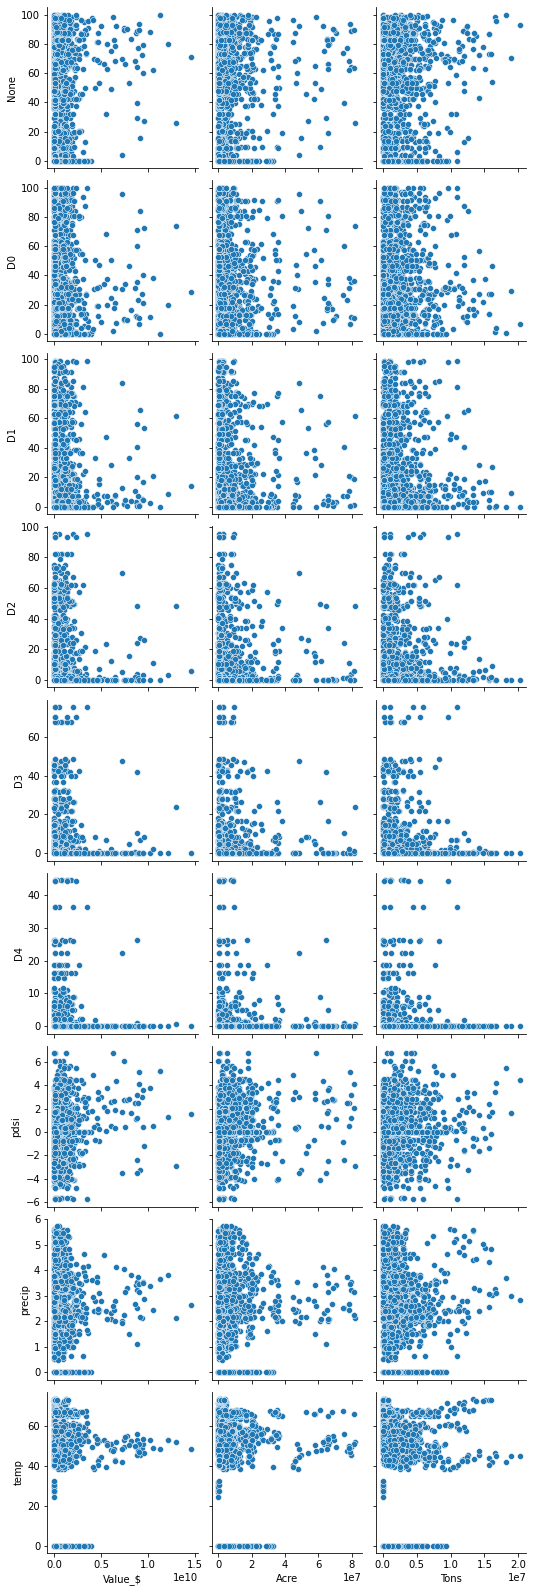

In [33]:
sns.pairplot(data = df_pairplot,
             y_vars=['None', 'D0', 'D1', 'D2', 'D3', 'D4', 'pdsi', 'precip', 'temp'],
             x_vars=['Value_$','Acre','Tons'])

#### What crops are less affected by drought?
As we can now see the relationship of all the variables, now we can see which crop variable would be a good representation of the yield. Here we will use crop production yield in weight to compare among different crops.

In [34]:
df['Commodity'] = df['Commodity'].replace('HAY & HAYLAGE', 'HAY')
df

,Year,State,Commodity,Value_$,Acre,Tons,None,D0,D1,D2,D3,D4,pdsi,precip,temp
0,2010-01-01,Alabama,CORN,1.457630e+08,259000.0,1.350000e+05,58.051731,41.948269,23.075192,9.373269,2.024038,0.000000,-0.887500,3.932500,62.708333
1,2010-01-01,Alabama,COTTON,2.191940e+08,676000.0,1.490000e+05,58.051731,41.948269,23.075192,9.373269,2.024038,0.000000,-0.887500,3.932500,62.708333
2,2010-01-01,Alabama,HAY,3.182400e+08,1560000.0,1.872000e+06,58.051731,41.948269,23.075192,9.373269,2.024038,0.000000,-0.887500,3.932500,62.708333
3,2010-01-01,Alaska,HAY,7.320000e+06,20000.0,2.400000e+04,66.991538,33.008462,0.220385,0.000000,0.000000,0.000000,0.000000,2.820833,27.425000
4,2010-01-01,Arizona,CORN,2.679600e+07,45000.0,5.980000e+05,35.670385,64.329615,24.999423,8.702885,0.533654,0.000000,0.865000,1.159167,60.391667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,2020-01-01,Wisconsin,HAY,1.088592e+09,8370000.0,1.754571e+06,93.122692,6.877308,0.258654,0.007885,0.000000,0.000000,4.420000,2.849167,44.825000
1659,2020-01-01,Wisconsin,HAY,2.307062e+09,4720000.0,4.828000e+06,93.122692,6.877308,0.258654,0.007885,0.000000,0.000000,4.420000,2.849167,44.825000
1660,2020-01-01,Wyoming,CORN,2.602300e+07,200000.0,5.000000e+05,41.825769,58.174231,42.290577,22.692500,8.695577,0.062308,-0.759167,0.976667,42.775000
1661,2020-01-01,Wyoming,HAY,9.173700e+08,7790000.0,1.513000e+06,41.825769,58.174231,42.290577,22.692500,8.695577,0.062308,-0.759167,0.976667,42.775000


In [35]:
# compare crop yield correlation
crop_avg_df = df.groupby(['Year', 'Commodity'])['Acre','Tons','None','D0',	'D1','D2','D3','D4','pdsi','precip','temp'].mean().reset_index()
crop_avg_df = crop_avg_df.pivot(index='Year', columns='Commodity', values='Tons').reset_index()
crop_drought_corr = crop_avg_df.merge(avg_df[['Year', 'D3', 'pdsi', 'precip', 'temp']], on='Year')
crop_drought_corr = crop_drought_corr.corr()
crop_drought_corr

,CORN,COTTON,HAY,SORGHUM,SUGARBEETS,SUGARCANE,D3,pdsi,precip,temp
CORN,1.000000,-0.208640,-0.462567,0.695311,0.000567,0.750484,-0.381982,0.492344,0.480683,0.174198
COTTON,-0.208640,1.000000,0.038453,-0.106350,-0.213660,0.183012,-0.426115,0.206071,-0.072780,0.168994
HAY,-0.462567,0.038453,1.000000,-0.319147,-0.245833,-0.643106,-0.299769,0.212277,-0.208258,-0.571195
SORGHUM,0.695311,-0.106350,-0.319147,1.000000,-0.249126,0.563080,-0.321476,0.590938,0.305597,-0.083403
SUGARBEETS,0.000567,-0.213660,-0.245833,-0.249126,1.000000,-0.135004,0.275240,-0.553401,-0.290289,0.612181
SUGARCANE,0.750484,0.183012,-0.643106,0.563080,-0.135004,1.000000,-0.484812,0.496345,0.635901,0.314505
D3,-0.381982,-0.426115,-0.299769,-0.321476,0.275240,-0.484812,1.000000,-0.861413,-0.537305,0.066170
pdsi,0.492344,0.206071,0.212277,0.590938,-0.553401,0.496345,-0.861413,1.000000,0.636385,-0.241870
precip,0.480683,-0.072780,-0.208258,0.305597,-0.290289,0.635901,-0.537305,0.636385,1.000000,-0.141349
temp,0.174198,0.168994,-0.571195,-0.083403,0.612181,0.314505,0.066170,-0.241870,-0.141349,1.000000


In [36]:
# display vis
corrmatrix(crop_drought_corr)

alt.LayerChart(...)

In [37]:
crop_drought_corr.sort_values('pdsi').index

Index(['D3', 'SUGARBEETS', 'temp', 'COTTON', 'HAY', 'CORN', 'SUGARCANE',
       'SORGHUM', 'precip', 'pdsi'],
      dtype='object')

From this correlation matrix of each crop yields in tons to drought indicator, PDSI, we can see that the rank from least correlated are as follow.
1. Sugarbeets
2. Cotton
3. Hay
4. Corn
5. Sugarcane
6. Sorghum

## Explore Clustering of States Based on Variables
using K-Means to explore how each states would be clustered if we were to based on PDSI, Temperature and Precipitation variables. We first need to explore what is the optimal number of clustering using elbow method

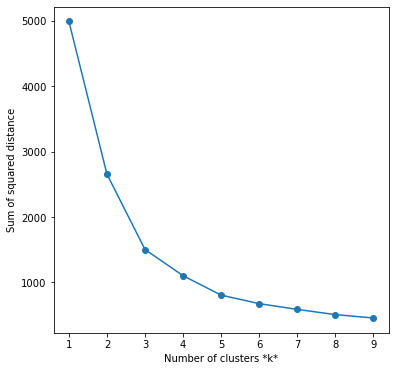

In [38]:
# Let's explore the clustering of drought and climate in state regions using K-Means
# first let's find optimal number of cluster using elbow methods

# stardize the data
df_clustering = df.copy()
df_clustering = df[['State','pdsi', 'temp', 'precip']]
X = StandardScaler().fit_transform(df_clustering.iloc[:, 1:])

sse=[] # sum of square error
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0)
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

#### No definite optimal K cluster found using elbow method

We need to find optimal cluster using silhouette score instead

In [39]:
# scaled features
df_clustering = df.copy()
df_clustering = df[['State','pdsi', 'temp', 'precip']]

# removing outlier from df_clustering keep only the ones that are within +2.5 to -2.5 standard deviations in the column 'Data'.
df_clustering[np.abs(df_clustering.pdsi-df_clustering.pdsi.mean()) <= (2.5*df_clustering.pdsi.std())]
df_clustering[np.abs(df_clustering.temp-df_clustering.temp.mean()) <= (2.5*df_clustering.temp.std())]
df_clustering[np.abs(df_clustering.precip-df_clustering.precip.mean()) <= (2.5*df_clustering.precip.std())]
df_clustering

# scale the data
X = StandardScaler().fit_transform(df_clustering.iloc[:,1:])
df_scaled = pd.DataFrame(X, columns=['pdsi', 'temp', 'precip'])

# label encoding
states = df_clustering.State.tolist()
state_label = LabelEncoder().fit_transform(states)

# merge label with scaled features
df_scaled['state_label'] = state_label

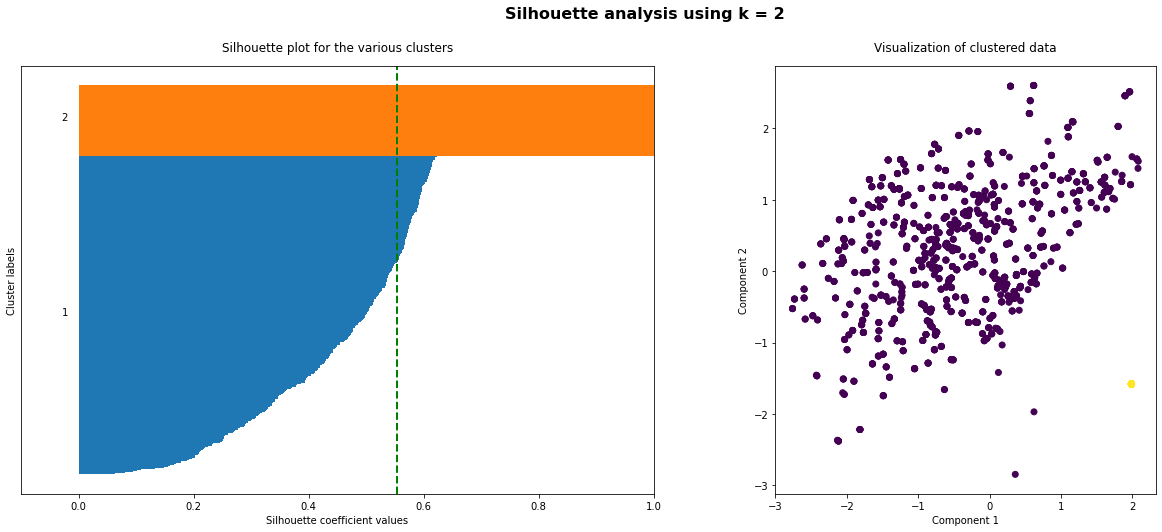

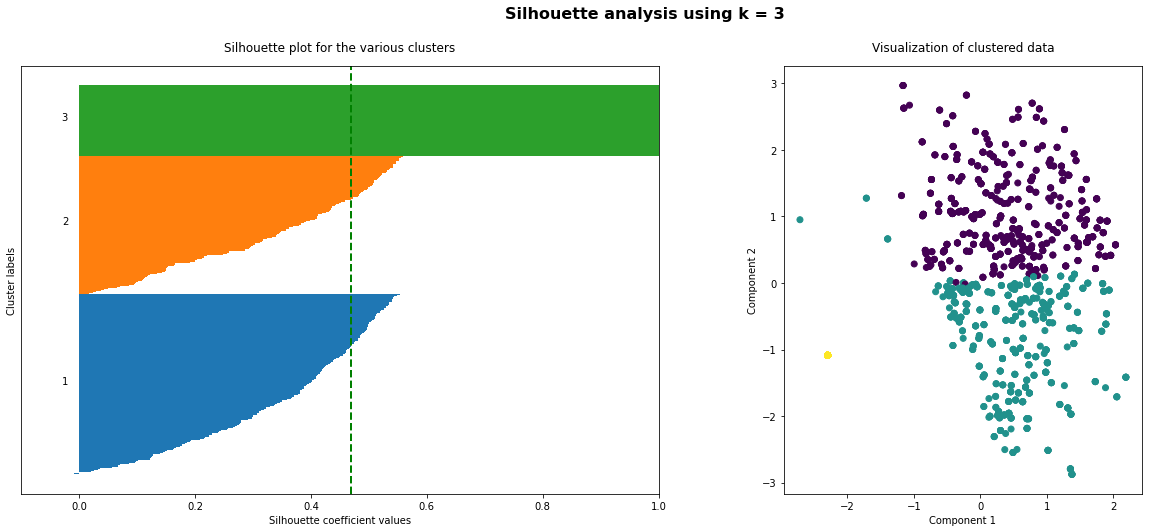

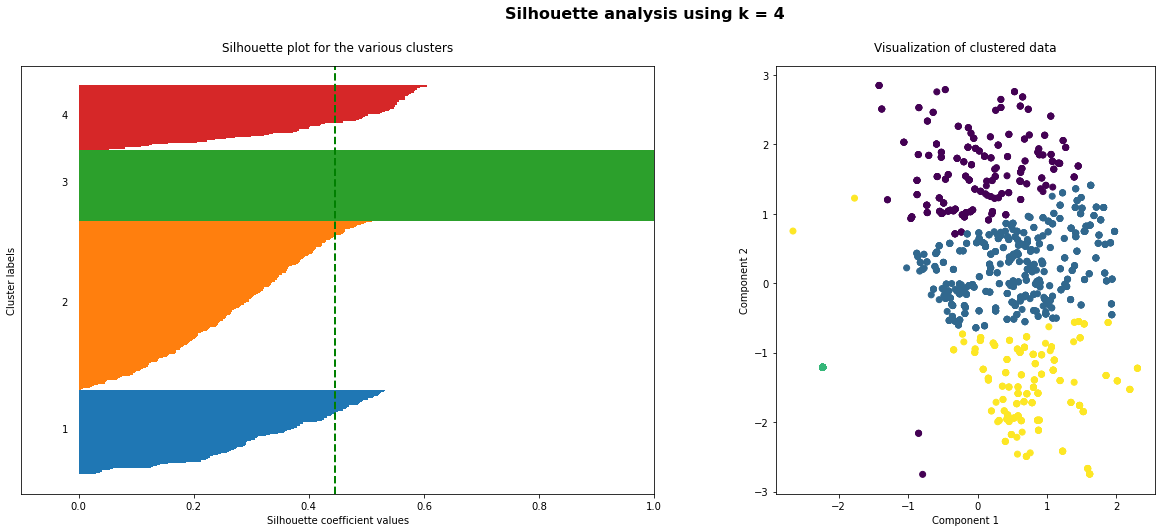

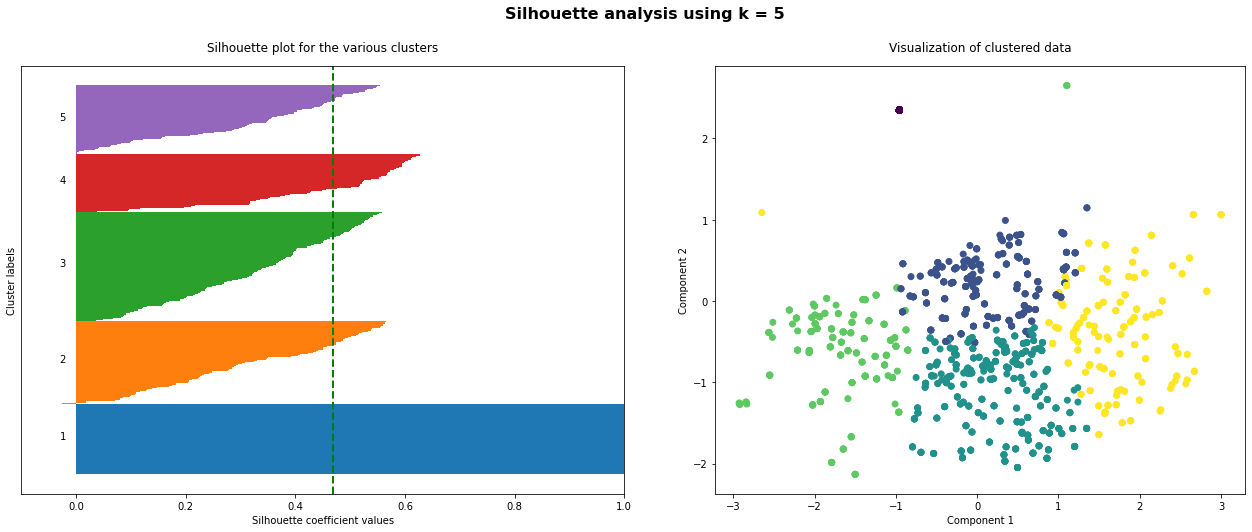

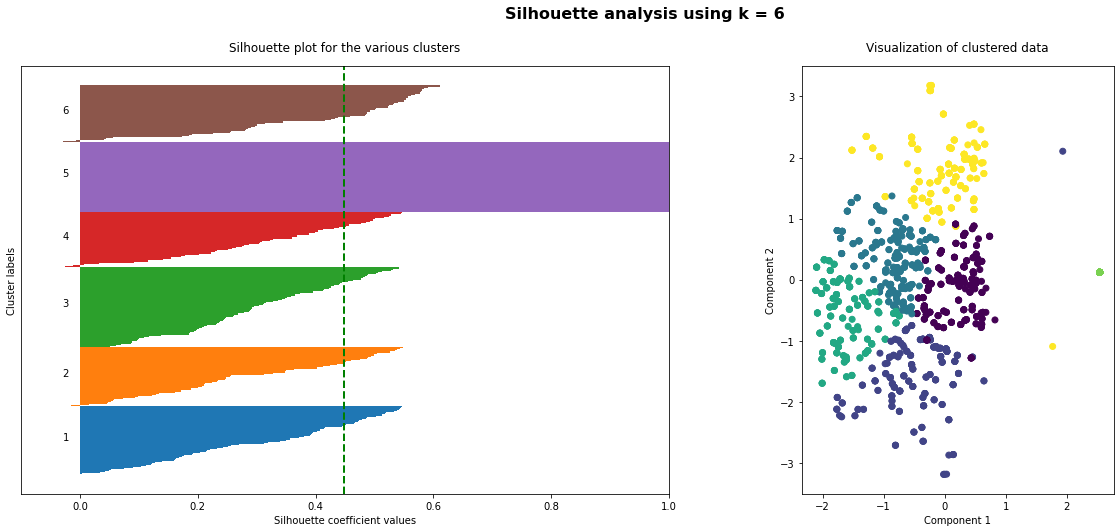

In [40]:
for i, k in enumerate([2, 3, 4, 5, 6]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0)
    labels = kmeans.fit_predict(X)
    # centroids = kmeans.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Use MDS to flatten the data
    embedding = MDS(n_components=2)
    mds = pd.DataFrame(embedding.fit_transform(X), columns = ['component1','component2'])
    mds['labels'] = kmeans.predict(X)

    # Scatter plot of data colored with labels
    ax2.scatter(mds['component1'], mds['component2'], c=labels)
    # ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    # ax2.set_xlim([-2, 2])
    # ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In [41]:


# using kmean clustering to find state cluster based on variables
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0).fit(X)

# sns.scatterplot(data=mds, x = "component1", y="component2", hue="cluster")

df_scaled['clustering'] = kmeans.predict(X)
df_scaled['State'] = df_clustering['State']
df_scaled


,pdsi,temp,precip,state_label,clustering,State
0,-0.568356,0.805460,0.807138,0,2,Alabama
1,-0.568356,0.805460,0.807138,0,2,Alabama
2,-0.568356,0.805460,0.807138,0,2,Alabama
3,-0.134137,-0.769773,0.142661,1,1,Alaska
4,0.289073,0.702032,-0.850568,2,1,Arizona
...,...,...,...,...,...,...
1658,2.028396,0.007054,0.159596,48,4,Wisconsin
1659,2.028396,0.007054,0.159596,48,4,Wisconsin
1660,-0.505568,-0.084469,-0.959654,49,1,Wyoming
1661,-0.505568,-0.084469,-0.959654,49,1,Wyoming


In [42]:
state_group_gdf = pd.merge(df_scaled, geo_gdf, on='State', how='left')
gdf = gpd.GeoDataFrame(state_group_gdf)
m = folium.Map([43, -100], zoom_start=4.5, tiles='Stamen Terrain')
# geo = gdf.explore(column='clustering', m=m, cmap='gnuplot', legend=True, scheme='EqualInterval', k=5)
# geo